# An initial training pipeline

In [ ]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()


In [ ]:
cat_file = os.path.join(
    os.getenv("PRICE_CSV_DATA"), 
    'symbols_valid_meta.csv'
)
cat_df = (pd.read_csv(cat_file)
          .rename(columns = {'Symbol': 'ticker'})[['ticker', 'Listing Exchange', 'Market Category']]
          )
df = df.merge(cat_df, on = 'ticker', how = 'left')


## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [10]:
df.columns

Index(['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'source', 'Year', 'Close_lag_1', 'Listing Exchange_x',
       'Market Category_x', 'Listing Exchange_y', 'Market Category_y',
       'Listing Exchange', 'Market Category'],
      dtype='object')

In [12]:
df = (df.assign(
        returns = lambda x: x['Close']/x['Close_lag_1'] - 1, 
        positive_return = lambda x: 1.0*(x['returns'] > 0),
        hi_lo = lambda x: x['High'] - x['Low'],
        op_cl = lambda x: x['Close'] - x['Open']
    ).groupby(['ticker'], group_keys=False).apply(
        lambda x: x.assign(target = x['positive_return'].shift(-1))
    )
    .reset_index(drop=True)
    .dropna(subset = ['target'])
    )
df

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,...,Market Category_x,Listing Exchange_y,Market Category_y,Listing Exchange,Market Category,returns,positive_return,hi_lo,op_cl,target
0,A,2014-01-03,40.336193,41.022888,40.243206,40.715309,38.229481,2609600.0,A.csv,2014,...,,N,,N,,0.012631,1.0,0.779682,0.379116,0.0
1,A,2014-01-06,41.058655,41.273247,40.457798,40.515022,38.041428,2484600.0,A.csv,2014,...,,N,,N,,-0.004919,0.0,0.815449,-0.543633,1.0
2,A,2014-01-07,40.736767,41.223175,40.722462,41.094421,38.585449,2045500.0,A.csv,2014,...,,N,,N,,0.014301,1.0,0.500713,0.357655,1.0
3,A,2014-01-08,41.008583,41.874107,40.894135,41.766811,39.216789,3717900.0,A.csv,2014,...,,N,,N,,0.016362,1.0,0.979973,0.758228,1.0
4,A,2014-01-09,41.773964,41.974251,41.394852,41.781116,39.230221,2457100.0,A.csv,2014,...,,N,,N,,0.000342,1.0,0.579399,0.007153,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313504,ZEUS,2005-06-24,14.430000,14.550000,14.150000,14.170000,12.977926,201000.0,ZEUS.csv,2005,...,Q,Q,Q,Q,Q,-0.025447,0.0,0.400001,-0.260000,0.0
313505,ZEUS,2005-06-27,14.080000,14.330000,13.660000,13.730000,12.574939,273200.0,ZEUS.csv,2005,...,Q,Q,Q,Q,Q,-0.031052,0.0,0.670000,-0.350000,1.0
313506,ZEUS,2005-06-28,13.830000,14.360000,13.830000,14.150000,12.959603,290100.0,ZEUS.csv,2005,...,Q,Q,Q,Q,Q,0.030590,1.0,0.530000,0.320000,0.0
313507,ZEUS,2005-06-29,14.200000,14.250000,13.650000,13.840000,12.675684,145400.0,ZEUS.csv,2005,...,Q,Q,Q,Q,Q,-0.021908,0.0,0.600000,-0.360000,0.0


In [13]:
returns = df[['returns']]

In [15]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit(returns)

StandardScaler()

In [16]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns)
scaled_returns = pd.DataFrame(scaled_returns_np, columns=returns.columns)
scaled_returns.describe()

,returns
count,3.134220e+05
mean,-3.513924e-19
std,1.000002e+00
min,-6.374665e-03
25%,-2.707055e-03
50%,-2.664992e-03
75%,-2.624444e-03
max,5.530226e+02


###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='Listing Exchange'>

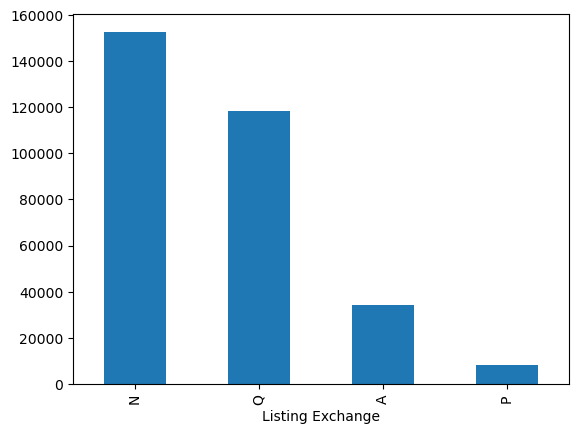

In [17]:
df['Listing Exchange'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [28]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(drop = 'first')
onehot.fit(df[['Listing Exchange']])

OneHotEncoder(drop='first')

In [29]:
listing_enc = onehot.fit_transform(df[['Listing Exchange']])
listing_enc.toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [30]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [31]:
X0 = df[['Listing Exchange', 'Market Category']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [32]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [33]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [34]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res


{'accuracy_score_train': 0.5591356680505869,
 'accuracy_score_test': 0.5607561617611869,
 'cohen_kappa_train': 0.0,
 'cohen_kappa_test': 0.0,
 'log_loss_train': 0.6828891549341145,
 'log_loss_test': 0.6823838947402037,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [27]:
from sklearn.compose import ColumnTransformer

In [35]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume', 'op_cl', 'hi_lo'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Listing Exchange', 'Market Category']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)
pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric_transfomer',
                                                  StandardScaler(),
                                                  ['returns', 'Volume', 'op_cl',
                                                   'hi_lo']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Listing Exchange',
                                                   'Market Category'])])),
                ('decisiontree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [36]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [37]:
# Schema
X = df[['returns', 'op_cl', 'hi_lo', 'Volume', 'Listing Exchange', 'Market Category']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [38]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6718773489078965,
 'log_loss_test': 0.6709691728203926,
 'cohen_kappa_train': 0.0017509626884367746,
 'cohen_kappa_test': 0.002312878605218338,
 'f1_score_train': 0.004519189693549475,
 'f1_score_test': 0.005286905792807985,
 'accuracy_score_train': 0.5585400994072457,
 'accuracy_score_test': 0.5647882268485284}

In [39]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6225527090157216,
 'log_loss_test': 1.5570169280579707,
 'cohen_kappa_train': 0.1866279596858953,
 'cohen_kappa_test': 0.0918652667901887,
 'f1_score_train': 0.5396517375803054,
 'f1_score_test': 0.48573596009287145,
 'accuracy_score_train': 0.6002622277393077,
 'accuracy_score_test': 0.5539004546542236}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [40]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In [41]:
d3_dict

{'fit_time': array([1.4459579 , 1.57808113, 1.43669987, 1.43854594, 1.49094772]),
 'score_time': array([0.15771389, 0.16249299, 0.16562414, 0.15384316, 0.16037917]),
 'test_accuracy': array([0.54009731, 0.55234905, 0.51805883, 0.55674494, 0.54718908]),
 'train_accuracy': array([0.59600298, 0.59610668, 0.61011494, 0.59602454, 0.59665069]),
 'test_f1': array([0.44522275, 0.37903029, 0.41937344, 0.26994929, 0.30919003]),
 'train_f1': array([0.48859787, 0.49094958, 0.52559604, 0.41843027, 0.38835433]),
 'test_precision': array([0.47507187, 0.4873108 , 0.44685644, 0.49186136, 0.47146144]),
 'train_precision': array([0.55229008, 0.5519264 , 0.56642296, 0.57195103, 0.58494416]),
 'test_recall': array([0.41890277, 0.31012131, 0.39507514, 0.18602209, 0.23001992]),
 'train_recall': array([0.43807713, 0.44210574, 0.49025892, 0.32988412, 0.2906663 ]),
 'test_roc_auc': array([0.54427253, 0.56380843, 0.52300922, 0.56192543, 0.56062354]),
 'train_roc_auc': array([0.64850952, 0.64849967, 0.66858894, 0

In DataFrame form:

In [42]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,1.445958,0.157714,0.540097,0.596003,0.445223,0.488598,0.475072,0.552290,0.418903,0.438077,0.544273,0.648510,-3.313538,-0.628132,-0.284403,-0.223096
1,1.578081,0.162493,0.552349,0.596107,0.379030,0.490950,0.487311,0.551926,0.310121,0.442106,0.563808,0.648500,-1.512837,-0.626809,-0.255828,-0.222860
2,1.436700,0.165624,0.518059,0.610115,0.419373,0.525596,0.446856,0.566423,0.395075,0.490259,0.523009,0.668589,-1.921851,-0.617809,-0.270582,-0.218943
3,1.438546,0.153843,0.556745,0.596025,0.269949,0.418430,0.491861,0.571951,0.186022,0.329884,0.561925,0.646488,-2.280270,-0.629729,-0.265390,-0.223898
4,1.490948,0.160379,0.547189,0.596651,0.309190,0.388354,0.471461,0.584944,0.230020,0.290666,0.560624,0.649893,-1.867277,-0.625921,-0.258435,-0.222450


In [43]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,1.435112,0.156952,0.540624,0.595931,0.445399,0.488223,0.475707,0.552253,0.418722,0.437498,0.545479,0.648408,-3.325886,-0.628173,-0.284105,-0.223108
1,1.576792,0.159760,0.552190,0.596051,0.378672,0.490767,0.487019,0.551873,0.309759,0.441843,0.563686,0.648281,-1.499665,-0.626962,-0.255675,-0.222924
2,1.447881,0.163240,0.518075,0.610135,0.420584,0.526046,0.447109,0.566321,0.397031,0.491119,0.523068,0.668659,-1.946465,-0.617791,-0.270846,-0.218934
3,1.442396,0.159723,0.556713,0.595993,0.269666,0.418511,0.491756,0.571845,0.185769,0.330020,0.561940,0.646470,-2.287861,-0.629673,-0.265437,-0.223888
4,1.492636,0.157827,0.546742,0.596455,0.308003,0.389583,0.470356,0.583867,0.228970,0.292314,0.559858,0.649612,-1.871807,-0.626130,-0.258719,-0.222534


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [44]:
pd.DataFrame(d15_dict).mean()

fit_time                 1.478963
score_time               0.159500
test_accuracy            0.542869
train_accuracy           0.598913
test_f1                  0.364465
train_f1                 0.462626
test_precision           0.474389
train_precision          0.565232
test_recall              0.308050
train_recall             0.398559
test_roc_auc             0.550806
train_roc_auc            0.652286
test_neg_log_loss       -2.186337
train_neg_log_loss      -0.625746
test_neg_brier_score    -0.266957
train_neg_brier_score   -0.222278
dtype: float64

In [45]:
pd.DataFrame(d3_dict).mean()

fit_time                 1.478047
score_time               0.160011
test_accuracy            0.542888
train_accuracy           0.598980
test_f1                  0.364553
train_f1                 0.462386
test_precision           0.474512
train_precision          0.565507
test_recall              0.308028
train_recall             0.398198
test_roc_auc             0.550728
train_roc_auc            0.652396
test_neg_log_loss       -2.179154
train_neg_log_loss      -0.625680
test_neg_brier_score    -0.266928
train_neg_brier_score   -0.222249
dtype: float64